# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import math
import shutil
import random
import csv


# Oxford Flower Image Dataset


## TODO: 

## there only seems to be 32 images in the final "oxfordflowers" folder (one image for each other flower types). This should instead be a master oxford flowers dataset that contains multiple images of each kind of flower for model training purposes. 

## This problem seems to persist throughtout the other datasets as well - CHECK ALL DATASETS FOR COMPLETE IMAGE PORTOVER


Category ID: 21, Class Name: fire_lily
Category ID: 3, Class Name: canterbury_bells
Category ID: 45, Class Name: bolero_deep_blue
Category ID: 1, Class Name: pink_primrose
Category ID: 34, Class Name: mexican_aster
Category ID: 27, Class Name: prince_of_wales_feathers
Category ID: 7, Class Name: moon_orchid
Category ID: 16, Class Name: globe-flower
Category ID: 25, Class Name: grape_hyacinth
Category ID: 26, Class Name: corn_poppy
Found 6552 images belonging to 102 classes.
Found 0 images belonging to 0 classes.
Class indices: {'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47

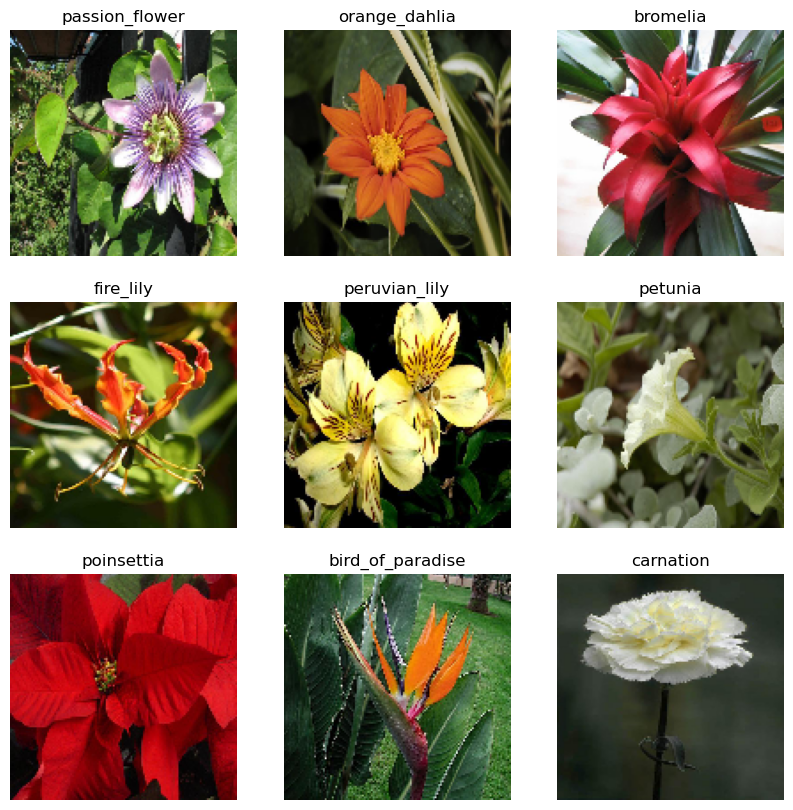

In [16]:
# Paths
oxford_flower_dataset_path = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_identifcation_resources/testflowers/dataset'
json_file_path = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_identifcation_resources/testflowers/cat_to_name.json'
oxford_flowers_folder = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_dr_master_dataset/102_oxford_flowers'
csv_file_path = os.path.join(oxford_flowers_folder, 'image_labels.csv')

# Ensure the output directory exists
os.makedirs(oxford_flowers_folder, exist_ok=True)

# Load the JSON file with category to name mappings
with open(json_file_path, 'r') as f:
    cat_to_name = json.load(f)

# Update the class names to replace spaces with underscores
cat_to_name = {key: value.replace(' ', '_') for key, value in cat_to_name.items()}

# Print a few sample mappings to inspect
for i, (key, value) in enumerate(cat_to_name.items()):
    if i < 10:
        print(f"Category ID: {key}, Class Name: {value}")
    else:
        break

# Function to rename folders and files with underscores
def replace_spaces_with_underscores(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir, topdown=False):
        for filename in filenames:
            if ' ' in filename:
                new_filename = filename.replace(' ', '_')
                os.rename(os.path.join(dirpath, filename), os.path.join(dirpath, new_filename))
        for dirname in dirnames:
            if ' ' in dirname:
                new_dirname = dirname.replace(' ', '_')
                os.rename(os.path.join(dirpath, dirname), os.path.join(dirpath, new_dirname))

replace_spaces_with_underscores(oxford_flower_dataset_path)

# ImageDataGenerator setup
img_size = (128, 128)
datagen = ImageDataGenerator(rescale=1./255)

# Load training and validation data
train_generator = datagen.flow_from_directory(
    os.path.join(oxford_flower_dataset_path, 'train'),
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)
valid_generator = datagen.flow_from_directory(
    os.path.join(oxford_flower_dataset_path, 'valid'),
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

# Print class indices to verify the mapping
print("Class indices:", train_generator.class_indices)

# Check existing entries in the CSV file to prevent duplicates
existing_filenames = set()
if os.path.exists(csv_file_path):
    with open(csv_file_path, mode='r') as csv_file:
        reader = csv.DictReader(csv_file)
        for row in reader:
            existing_filenames.add(row['filename'])

# Open the CSV file for writing (append mode)
with open(csv_file_path, mode='a', newline='') as csv_file:
    fieldnames = ['filename', 'label']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    if not existing_filenames:  # Write header only if the file is empty
        writer.writeheader()

    # Iterate over the entire dataset using the data generator
    for batch_index in range(len(train_generator)):
        # Get a batch of images and labels
        images, labels = next(train_generator)

        # Loop through the images and labels to save them with correct filenames
        for i in range(len(images)):
            # Get the image array and convert it to a PIL Image
            image_array = images[i]
            image = Image.fromarray((image_array * 255).astype('uint8'))  # Convert from normalized to pixel values if needed

            # Get the class index and map it to the correct class name
            class_index = labels[i].argmax()  # Find the class index
            class_name = list(train_generator.class_indices.keys())[class_index]

            # Map the class name to the human-readable label using the JSON file
            human_readable_label = cat_to_name.get(class_name, "Unknown")

            # Define the file name and save path
            filename = f"{human_readable_label}_{batch_index}_{i+1}.jpg"
            save_path = os.path.join(oxford_flowers_folder, filename)

            # Check if the file already exists
            if filename not in existing_filenames:
                # Save the image
                image.save(save_path)

                # Write the filename and label to the CSV file
                writer.writerow({'filename': filename, 'label': human_readable_label})

                print(f"Saved image {filename} and wrote to CSV with label {human_readable_label}")
            else:
                print(f"Skipped existing image {filename}")

# Optionally, display the first 9 images to verify
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

    # Get the class index and map it to the correct class name
    class_index = labels[i].argmax()  # Find the class index
    class_name = list(train_generator.class_indices.keys())[class_index]

    # Map the class name to the human-readable label using the JSON file
    human_readable_label = cat_to_name.get(class_name, "Unknown")
    
    # Append "_healthy" to the label
    if human_readable_label != "Unknown":
        human_readable_label += "_healthy"
   
    plt.title(human_readable_label)

plt.show()


In [2]:
# Define the path to the flower dataset
oxford_flower_dataset_path = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_identifcation_resources/testflowers/dataset'

# List the directories within the dataset (train, test, valid)
print("Dataset directories:", os.listdir(oxford_flower_dataset_path))

# List the classes in the train directory as an example
train_dir = os.path.join(oxford_flower_dataset_path, 'train')
print("Classes in train directory:", os.listdir(train_dir))


Dataset directories: ['valid', '.DS_Store', 'test', 'train']
Classes in train directory: ['61', '95', '59', '92', '66', '50', '68', '57', '32', '35', '102', '69', '56', '51', '58', '67', '93', '94', '60', '34', '33', '.DS_Store', '20', '18', '27', '9', '11', '7', '29', '16', '42', '89', '45', '73', '87', '80', '74', '6', '28', '17', '1', '10', '19', '26', '8', '21', '75', '81', '86', '72', '44', '43', '88', '38', '36', '31', '91', '65', '62', '96', '100', '54', '98', '53', '30', '37', '39', '99', '52', '101', '55', '97', '63', '64', '90', '46', '79', '41', '83', '77', '48', '70', '84', '24', '23', '4', '15', '3', '12', '85', '71', '76', '82', '49', '40', '47', '78', '2', '13', '5', '14', '22', '25']


In [3]:
# Load the JSON file with category to name mappings
json_file_path = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_identifcation_resources/testflowers/cat_to_name.json'
with open(json_file_path, 'r') as f:
    cat_to_name = json.load(f)

# Update the class names to replace spaces with underscores
for key, value in cat_to_name.items():
    cat_to_name[key] = value.replace(' ', '_')

# Print a few sample mappings to inspect
for i, (key, value) in enumerate(cat_to_name.items()):
    if i < 10:
        print(f"Category ID: {key}, Class Name: {value}")
    else:
        break


Category ID: 21, Class Name: fire_lily
Category ID: 3, Class Name: canterbury_bells
Category ID: 45, Class Name: bolero_deep_blue
Category ID: 1, Class Name: pink_primrose
Category ID: 34, Class Name: mexican_aster
Category ID: 27, Class Name: prince_of_wales_feathers
Category ID: 7, Class Name: moon_orchid
Category ID: 16, Class Name: globe-flower
Category ID: 25, Class Name: grape_hyacinth
Category ID: 26, Class Name: corn_poppy


In [4]:
# # Update the keys by replacing spaces with underscores
# updated_cat_to_name = {key.replace(' ', '_'): value for key, value in cat_to_name.items()}

# # Save the updated dictionary back to the JSON file
# with open('/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_identifcation_resources/testflowers/cat_to_name.json', 'w') as f:
#     json.dump(updated_cat_to_name, f, indent=4)

# print("JSON file has been updated with underscores in the keys.")

JSON file has been updated with underscores in the keys.


In [5]:
def replace_spaces_with_underscores(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir, topdown=False):
        # Rename files
        for filename in filenames:
            if ' ' in filename:
                new_filename = filename.replace(' ', '_')
                os.rename(os.path.join(dirpath, filename), os.path.join(dirpath, new_filename))
                print(f"Renamed file: {filename} -> {new_filename}")
        
        # Rename directories
        for dirname in dirnames:
            if ' ' in dirname:
                new_dirname = dirname.replace(' ', '_')
                os.rename(os.path.join(dirpath, dirname), os.path.join(dirpath, new_dirname))
                print(f"Renamed directory: {dirname} -> {new_dirname}")
                
# Run the function to replace spaces with underscores
replace_spaces_with_underscores(oxford_flower_dataset_path)


In [6]:
# Run the function to replace spaces with underscores
replace_spaces_with_underscores(oxford_flower_dataset_path)


In [7]:
# Image size
img_size = (128, 128)

# Create an ImageDataGenerator for loading and preprocessing images
datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = datagen.flow_from_directory(
    os.path.join(oxford_flower_dataset_path, 'train'),
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

# Load validation data
valid_generator = datagen.flow_from_directory(
    os.path.join(oxford_flower_dataset_path, 'valid'),
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)


Found 6552 images belonging to 102 classes.
Found 818 images belonging to 102 classes.


In [8]:
# Define the path to the test directory
test_dir = os.path.join(oxford_flower_dataset_path, 'test')

# Get a list of all images in the test directory
image_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff', 'gif'))]

# Create a DataFrame for the test data
test_df = pd.DataFrame({
    'filename': image_paths,
    'class': ['unknown'] * len(image_paths)  # Use 'unknown' or some placeholder since class_mode=None
})

# Create an ImageDataGenerator for loading and preprocessing images
datagen = ImageDataGenerator(rescale=1./255)

# Use flow_from_dataframe to load the test data
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col=None,  # No labels
    target_size=img_size,
    batch_size=32,
    class_mode=None,
    shuffle=False
)

# Verify the generator has loaded the images
images = next(test_generator)
print(f"Loaded {len(images)} images from the test set.")


Found 819 validated image filenames.
Loaded 32 images from the test set.


In [9]:
# Inspect how class names are being interpreted
print("Class indices:", train_generator.class_indices)


Class indices: {'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '95': 97, '96': 98, '97': 99, 

In [11]:
# Image size
img_size = (128, 128)

# Custom function to rename the class folders with combined labels
def rename_class_folders(base_path):
    for plant_folder in os.listdir(base_path):
        plant_path = os.path.join(base_path, plant_folder)
        if os.path.isdir(plant_path):
            for status_folder in os.listdir(plant_path):
                status_path = os.path.join(plant_path, status_folder)
                if os.path.isdir(status_path):
                    # Create the new combined label name
                    combined_label = f"{plant_folder}_{status_folder}".lower().replace(' ', '_')
                    # Rename the folder to reflect the combined label
                    new_status_path = os.path.join(base_path, combined_label)
                    shutil.move(status_path, new_status_path)

# Rename the folders
rename_class_folders(oxford_flower_dataset_path)

# Create an ImageDataGenerator for loading and preprocessing images
datagen = ImageDataGenerator(rescale=1./255)

# Load all data, treating each health status as a sub-class
data_generator = datagen.flow_from_directory(
    oxford_flower_dataset_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Keep shuffle off to ensure consistent labeling
)

# Print class indices to see how classes are interpreted
print("Class indices:", data_generator.class_indices)

# Define the path to the new folder where images will be saved
oxford_flowers_folder = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_dr_master_dataset/102_oxford_flowers'
os.makedirs(oxford_flowers_folder, exist_ok=True)

# Define the path to the CSV file where labels will be stored
csv_file_path = os.path.join(oxford_flowers_folder, 'image_labels.csv')

# Check existing entries in the CSV file
existing_filenames = set()
if os.path.exists(csv_file_path):
    with open(csv_file_path, mode='r') as csv_file:
        reader = csv.DictReader(csv_file)
        for row in reader:
            existing_filenames.add(row['filename'])

# Open the CSV file for writing (append mode)
with open(csv_file_path, mode='a', newline='') as csv_file:
    fieldnames = ['filename', 'label']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    if not existing_filenames:  # Write header only if the file is empty
        writer.writeheader()

    # Iterate over the entire dataset using the data generator
    for batch_index in range(len(data_generator)):
        # Get a batch of images and labels
        images, labels = next(data_generator)

        # Loop through the images and labels to save them with correct filenames
        for i in range(len(images)):
            # Get the image array and convert it to a PIL Image
            image_array = images[i]
            image = Image.fromarray((image_array * 255).astype('uint8'))  # Convert from normalized to pixel values if needed

            # Get the class index and map it to the correct class name
            class_index = labels[i].argmax()  # Find the class index
            class_name = list(data_generator.class_indices.keys())[class_index]

            # Use the combined label (since you've already renamed the folders)
            human_readable_label = class_name

            # Define the file name and save path
            filename = f"{human_readable_label}_{batch_index}_{i+1}.jpg"
            save_path = os.path.join(oxford_flowers_folder, filename)

            # Check if the file already exists
            if filename not in existing_filenames:
                # Save the image
                image.save(save_path)

                # Write the filename and label to the CSV file
                writer.writerow({'filename': filename, 'label': human_readable_label})

                print(f"Saved image {filename} and wrote to CSV with label {human_readable_label}")
            else:
                print(f"Skipped existing image {filename}")


Found 8189 images belonging to 207 classes.
Class indices: {'test': 0, 'train': 1, 'train_1': 2, 'train_10': 3, 'train_100': 4, 'train_101': 5, 'train_102': 6, 'train_11': 7, 'train_12': 8, 'train_13': 9, 'train_14': 10, 'train_15': 11, 'train_16': 12, 'train_17': 13, 'train_18': 14, 'train_19': 15, 'train_2': 16, 'train_20': 17, 'train_21': 18, 'train_22': 19, 'train_23': 20, 'train_24': 21, 'train_25': 22, 'train_26': 23, 'train_27': 24, 'train_28': 25, 'train_29': 26, 'train_3': 27, 'train_30': 28, 'train_31': 29, 'train_32': 30, 'train_33': 31, 'train_34': 32, 'train_35': 33, 'train_36': 34, 'train_37': 35, 'train_38': 36, 'train_39': 37, 'train_4': 38, 'train_40': 39, 'train_41': 40, 'train_42': 41, 'train_43': 42, 'train_44': 43, 'train_45': 44, 'train_46': 45, 'train_47': 46, 'train_48': 47, 'train_49': 48, 'train_5': 49, 'train_50': 50, 'train_51': 51, 'train_52': 52, 'train_53': 53, 'train_54': 54, 'train_55': 55, 'train_56': 56, 'train_57': 57, 'train_58': 58, 'train_59': 59,

In [ ]:
# Optionally, display the first 9 images to verify
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

    # Get the class index and map it to the correct class name
    class_index = labels[i].argmax()  # Find the class index
    class_name = list(train_generator.class_indices.keys())[class_index]

    # Map the class name to the human-readable label using the JSON file
    human_readable_label = cat_to_name.get(class_name, "Unknown")

    # Append "_healthy" to the label
    if human_readable_label != "Unknown":
        human_readable_label += "_healthy"

    plt.title(human_readable_label)

plt.show()

# General Leaf Image Dataset

In [ ]:
# Define the path to the leaf dataset
leaf_dataset_path = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_identifcation_resources/leaf_images'

# List the directories within the dataset (train, test, valid)
print("Dataset directories:", os.listdir(leaf_dataset_path))


In [ ]:
# Image size
img_size = (128, 128)

# Custom function to rename the class folders with combined labels
def rename_class_folders(base_path):
    for plant_folder in os.listdir(base_path):
        plant_path = os.path.join(base_path, plant_folder)
        if os.path.isdir(plant_path):
            for status_folder in os.listdir(plant_path):
                status_path = os.path.join(plant_path, status_folder)
                if os.path.isdir(status_path):
                    # Create the new combined label name
                    combined_label = f"{plant_folder}_{status_folder}".lower().replace(' ', '_')
                    # Rename the folder to reflect the combined label
                    new_status_path = os.path.join(base_path, combined_label)
                    shutil.move(status_path, new_status_path)

# Rename the folders
rename_class_folders(leaf_dataset_path)

# Create an ImageDataGenerator for loading and preprocessing images
datagen = ImageDataGenerator(rescale=1./255)

# Load all data, treating each health status as a sub-class
data_generator = datagen.flow_from_directory(
    leaf_dataset_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Keep shuffle off to ensure consistent labeling
)

# Print class indices to see how classes are interpreted
print("Class indices:", data_generator.class_indices)

# Define the path to the new folder where images will be saved
general_leaf_folder = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_dr_master_dataset/general_leaf_images'
os.makedirs(general_leaf_folder, exist_ok=True)

# Define the path to the CSV file where labels will be stored
csv_file_path = os.path.join(general_leaf_folder, 'image_labels.csv')

# Check existing entries in the CSV file
existing_filenames = set()
if os.path.exists(csv_file_path):
    with open(csv_file_path, mode='r') as csv_file:
        reader = csv.DictReader(csv_file)
        for row in reader:
            existing_filenames.add(row['filename'])

# Open the CSV file for writing (append mode)
with open(csv_file_path, mode='a', newline='') as csv_file:
    fieldnames = ['filename', 'label']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    if not existing_filenames:  # Write header only if the file is empty
        writer.writeheader()

    # Iterate over the entire dataset using the data generator
    for batch_index in range(len(data_generator)):
        # Get a batch of images and labels
        images, labels = next(data_generator)

        # Loop through the images and labels to save them with correct filenames
        for i in range(len(images)):
            # Get the image array and convert it to a PIL Image
            image_array = images[i]
            image = Image.fromarray((image_array * 255).astype('uint8'))  # Convert from normalized to pixel values if needed

            # Get the class index and map it to the correct class name
            class_index = labels[i].argmax()  # Find the class index
            class_name = list(data_generator.class_indices.keys())[class_index]

            # Use the combined label (since you've already renamed the folders)
            human_readable_label = class_name

            # Define the file name and save path
            filename = f"{human_readable_label}_{batch_index}_{i+1}.jpg"
            save_path = os.path.join(general_leaf_folder, filename)

            # Check if the file already exists
            if filename not in existing_filenames:
                # Save the image
                image.save(save_path)

                # Write the filename and label to the CSV file
                writer.writerow({'filename': filename, 'label': human_readable_label})

                print(f"Saved image {filename} and wrote to CSV with label {human_readable_label}")
            else:
                print(f"Skipped existing image {filename}")


In [ ]:
# Plot the first 9 images in the batch (from the last batch for example)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

    # Get the class index and map it to the class name
    class_index = labels[i].argmax()
    class_name = list(data_generator.class_indices.keys())[class_index]
    
    plt.title(class_name)

plt.show()

# Corn Image Dataset 

In [ ]:
# Define the path to the corn dataset
corn_dataset_path = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_identifcation_resources/corn_images'

# List the directories within the dataset (train, test, valid)
print("Dataset directories:", os.listdir(corn_dataset_path))


In [ ]:
# Image size
img_size = (128, 128)

# Create an ImageDataGenerator for loading and preprocessing images
datagen = ImageDataGenerator(rescale=1./255)

# Load all data, treating each health status as a sub-class
data_generator = datagen.flow_from_directory(
    corn_dataset_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

# Print class indices to see how classes are interpreted
print("Class indices:", data_generator.class_indices)


In [ ]:
# Get a batch of images and labels from the data generator
images, labels = next(data_generator)

# Print the shape of the images and labels to understand the batch size
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


In [ ]:
# Plot the first 9 images in the batch
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    
    # Get the class index and map it to the class name
    class_index = labels[i].argmax()  # Get the index of the maximum value in the one-hot encoded label
    class_name = list(data_generator.class_indices.keys())[class_index]

    # Modify the class name to include "corn_" and make everything lowercase with underscores
    modified_class_name = f"corn_{class_name.lower().replace(' ', '_')}"
    
    plt.title(modified_class_name)

plt.show()


# Major Crops Leaf Image Dataset

In [ ]:
# Define the path to the corn dataset
major_crops_dataset_path = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_identifcation_resources/major_crop_leaf_images/Plant_leaf_diseases_dataset_with_augmentation'

# List the directories within the dataset (train, test, valid)
print("Dataset directories:", os.listdir(major_crops_dataset_path))


In [ ]:
# Image size
img_size = (128, 128)

# Create an ImageDataGenerator for loading and preprocessing images
datagen = ImageDataGenerator(rescale=1./255)

# Load all data, treating each health status as a sub-class
data_generator = datagen.flow_from_directory(
    major_crops_dataset_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

# Print class indices to see how classes are interpreted
print("Class indices:", data_generator.class_indices)


In [ ]:
# Get a batch of images and labels from the data generator
images, labels = next(data_generator)

# Print the shape of the images and labels to understand the batch size
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


In [ ]:
# Plot the first 9 images in the batch
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    
    # Get the class index and map it to the class name
    class_index = labels[i].argmax()  # Get the index of the maximum value in the one-hot encoded label
    class_name = list(data_generator.class_indices.keys())[class_index]

     # Modify the class name to fit the desired pattern
    modified_class_name = class_name.replace('___', '_').lower()
    
    plt.title(modified_class_name)

plt.show()


# OLID (Open Leaf Image Dataset) of Bangladesh's Major Crops Dataset

In [ ]:
# Define the path to the OLID dataset
OLID_crops_dataset_path = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_identifcation_resources/OLID_images'

# List the directories within the dataset (train, test, valid)
print("Dataset directories:", os.listdir(OLID_crops_dataset_path))


In [ ]:
# Image size
img_size = (128, 128)

# Create an ImageDataGenerator for loading and preprocessing images
datagen = ImageDataGenerator(rescale=1./255)

# Load all data, treating each health status as a sub-class
data_generator = datagen.flow_from_directory(
    OLID_crops_dataset_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

# Print class indices to see how classes are interpreted
print("Class indices:", data_generator.class_indices)


In [ ]:
# Get a batch of images and labels from the data generator
images, labels = next(data_generator)

# Print the shape of the images and labels to understand the batch size
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


In [ ]:
# Load the Excel file
class_distribution = pd.read_excel('/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_identifcation_resources/OLID_images/class_distribution.xlsx')

# Display the first few rows to understand the structure
print(class_distribution.head())


In [ ]:
# Check the columns in the DataFrame
print(class_distribution.columns)


In [ ]:
# Assuming 'Class Abbrv.' is the abbreviation (e.g., 'N') and 'Class Full Form' is the full name
label_mapping = pd.Series(class_distribution['Class Full Form'].values, index=class_distribution['Class Abbrv.']).to_dict()

# Print the mapping to check it
print(label_mapping)


In [ ]:
def convert_label(image_label, label_mapping):
    # Split the image label to get the plant name and the code (e.g., 'ash_gourd_K' -> ['ash_gourd', 'K'])
    parts = image_label.split('__')
    
    if len(parts) < 2:
        # If the label doesn't split correctly, return it as is
        return image_label
    
    plant_name = parts[0]
    abbreviation = parts[1]

    # Handle NaN and mapping for abbreviation
    if abbreviation in label_mapping:
        full_form = label_mapping[abbreviation]
    elif abbreviation.lower() == "nan":
        full_form = "healthy"
    else:
        full_form = abbreviation.lower()  # Default to abbreviation if not found
    
    # Combine the plant name with the full form, converting to a suitable format
    full_label = f"{plant_name}_{full_form.lower().replace(' ', '_')}"
    return full_label


In [ ]:
# Example list of image labels from the data generator
original_labels = list(data_generator.class_indices.keys())

# Convert all image labels using the mapping function
converted_labels = [convert_label(label, label_mapping) for label in original_labels]

# Create a new mapping from the original class indices to the converted labels
mapped_class_indices = {orig: converted for orig, converted in zip(original_labels, converted_labels)}

# Print the new mapping to verify
print(mapped_class_indices)


In [ ]:
def display_images_with_labels(images, labels, mapped_class_indices):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis('off')

        # Get the class index and map it to the full class name
        class_index = labels[i].argmax()  # Get the index of the maximum value in the one-hot encoded label
        original_class_name = list(mapped_class_indices.keys())[class_index]  # Get the original class name
        full_class_name = mapped_class_indices.get(original_class_name, original_class_name)  # Get the full mapped name

        plt.title(full_class_name)

    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    
    plt.show()


In [ ]:
# Fetch a batch of images and labels
images, labels = next(data_generator)

# Display the images with their fully mapped labels
display_images_with_labels(images, labels, mapped_class_indices)


# Roboflow Plant Identification Dataset

In [ ]:
# Define the path to the plant id dataset
roboflow_plant_dataset_path = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_identifcation_resources/roboflow_plant_id'

# List the directories within the dataset (train, test, valid)
print("Dataset directories:", os.listdir(roboflow_plant_dataset_path))

# List the classes in the train directory as an example
train_dir = os.path.join(roboflow_plant_dataset_path, 'train')
print("Classes in train directory:", os.listdir(train_dir))


In [ ]:
# Load the class csv file
roboflow_class_distribution = pd.read_csv('/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_identifcation_resources/roboflow_plant_id/_classes.csv')

# Display the first few rows to understand the structure
print(roboflow_class_distribution.head())


In [ ]:
# Define the paths to the images
train_dir = os.path.join(roboflow_plant_dataset_path, 'train')
valid_dir = os.path.join(roboflow_plant_dataset_path, 'valid')

# Add the path to the images in the DataFrame
roboflow_class_distribution['filepath'] = roboflow_class_distribution['filename'].apply(lambda x: os.path.join(train_dir, x))

# Check the updated DataFrame
print(roboflow_class_distribution.head())


In [ ]:
# Remove leading and trailing spaces from all column names
roboflow_class_distribution.columns = roboflow_class_distribution.columns.str.strip()

# Check the cleaned column names
print(roboflow_class_distribution.columns)


In [ ]:
# Prepare the training generator with cleaned column names
train_generator = datagen.flow_from_dataframe(
    dataframe=roboflow_class_distribution,
    x_col='filepath',  # The column with the image paths
    y_col=['capsicum_healthy', 'chili_healthy', 'rosemary_healthy',
       'tarragon_healthy', 'thyme_healthy', 'tomato_healthy',
       'lettuce_healthy'],  # The cleaned column names
    target_size=(128, 128),
    batch_size=32,
    class_mode='raw'  # Use 'raw' if labels are not one-hot encoded
)


In [ ]:
# Fetch a batch of images and labels from the generator
images, labels = next(train_generator)

# Display the shape of the images and labels to understand the batch size
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


In [ ]:
# Example of adjusting column names if they have spaces or other differences
y_columns = ['capsicum_healthy', 'chili_healthy', 'rosemary_healthy',
       'tarragon_healthy', 'thyme_healthy', 'tomato_healthy',
       'lettuce_healthy']  # Adjust according to the actual DataFrame columns

# Create a mapping of class indices to class names
class_indices = {index: name for index, name in enumerate(y_columns)}

# Print the mapping to verify
print(class_indices)


In [ ]:
plt.figure(figsize=(12, 12))
for i in range(9):  # Display the first 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

    # Extract the labels for this image
    image_labels = labels[i]
    
    # Map the labels to their class names
    class_names = []
    for j, label in enumerate(image_labels):
        if label == 1:  # Assuming the label is 1 if the class is present
            class_name = class_indices[j]
            class_names.append(class_name)
            
    # Join the class names to display
    full_class_name = ', '.join(class_names)
    
    plt.title(full_class_name)

plt.show()

# Banana Leaf Nutrient Deficientcies Dataset

In [ ]:
# Define the path to the banana leaf dataset
banana_dataset_path = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_identifcation_resources/banana_nutrient_deficientcies'

# List the directories within the dataset (train, test, valid)
print("Dataset directories:", os.listdir(banana_dataset_path))


In [ ]:
# Image size
img_size = (128, 128)

# Create an ImageDataGenerator for loading and preprocessing images
datagen = ImageDataGenerator(rescale=1./255)

# Load all data, treating each health status as a sub-class
data_generator = datagen.flow_from_directory(
    banana_dataset_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

# Print class indices to see how classes are interpreted
print("Class indices:", data_generator.class_indices)


In [ ]:
# Get a batch of images and labels from the data generator
images, labels = next(data_generator)

# Print the shape of the images and labels to understand the batch size
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


In [ ]:
import os

def rename_folders_with_deficiency(base_path):
    # Iterate over all items in the base directory
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)
        
        # Check if the item is a directory and not the "healthy" folder
        if os.path.isdir(folder_path) and folder_name.lower() != 'healthy':
            # Check if the folder name already ends with "_deficiency"
            if not folder_name.lower().endswith('_deficiency'):
                # Rename the folder by adding "_deficiency"
                new_folder_name = f"{folder_name}_deficiency"
                new_folder_path = os.path.join(base_path, new_folder_name)
                os.rename(folder_path, new_folder_path)
                print(f"Renamed folder: {folder_name} -> {new_folder_name}")
            else:
                print(f"Folder {folder_name} already ends with '_deficiency'. Skipping...")

# Define the path to your dataset
banana_dataset_path = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_identifcation_resources/banana_nutrient_deficientcies'

# Run the function to rename folders
rename_folders_with_deficiency(banana_dataset_path)


In [ ]:
import os

def remove_extra_deficiency_suffix(base_path):
    # Iterate over all items in the base directory
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)
        
        # Check if the item is a directory and has the extra "_deficiency_deficiency" suffix
        if os.path.isdir(folder_path) and folder_name.lower().endswith('_deficiency_deficiency'):
            # Rename the folder by removing the extra "_deficiency"
            new_folder_name = folder_name.replace('_deficiency_deficiency', '_deficiency')
            new_folder_path = os.path.join(base_path, new_folder_name)
            os.rename(folder_path, new_folder_path)
            print(f"Renamed folder: {folder_name} -> {new_folder_name}")

# Define the path to your dataset
banana_dataset_path = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_identifcation_resources/banana_nutrient_deficientcies'

# Run the function to remove the extra suffix
remove_extra_deficiency_suffix(banana_dataset_path)


In [ ]:
# Plot the first 9 images in the batch
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    
    # Get the class index and map it to the class name
    class_index = labels[i].argmax()  # Get the index of the maximum value in the one-hot encoded label
    class_name = list(data_generator.class_indices.keys())[class_index]

    # Modify the class name to include "banana_" and make everything lowercase with underscores
    formatted_class_name = f"banana_{class_name.lower().replace(' ', '_')}"
    
    plt.title(formatted_class_name)

plt.show()


# Crop and Pest Diseases Dataset

In [ ]:
# Define the path to your dataset
crop_disease_dataset_path = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_identifcation_resources/crop_pest_and_disease'


In [ ]:
# Function to display images from the dataset
def display_images_manually(root_dir, num_images=9):
    # Collect all image file paths
    image_paths = []
    for plant_folder in os.listdir(root_dir):
        plant_path = os.path.join(root_dir, plant_folder)
        if os.path.isdir(plant_path):
            for disease_folder in os.listdir(plant_path):
                disease_path = os.path.join(plant_path, disease_folder)
                if os.path.isdir(disease_path):
                    for image_file in os.listdir(disease_path):
                        if image_file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff', 'gif')):
                            image_paths.append(os.path.join(disease_path, image_file))
    
    # Randomly select a few images to display
    selected_image_paths = random.sample(image_paths, num_images)
    
    # Plot the images
    plt.figure(figsize=(12, 12))
    for i, img_path in enumerate(selected_image_paths):
        plt.subplot(3, 3, i + 1)
        image = Image.open(img_path)
        plt.imshow(image)
        plt.axis('off')
        
        # Get the label for this image based on the path
        label = custom_labels.get(img_path, "Unknown")
        plt.title(label)
    
    plt.show()

# Call the function to display images
display_images_manually(crop_disease_dataset_path, num_images=9)


# PLANT DR MASTER DATASET